# Part 3: Gaussian Filters

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter as gaussian_filter_scipy

from src.filters import (
    first_order_x,
    first_order_y,
    log,
    second_order_xx,
    second_order_yy,
    zeroth_order,
)
from src.provided import astronaut, hubble, imshow
from src.steerable import (
    measure_orientation,
    oriented_filter,
    steer_the_filter,
    steer_the_images,
)

## Part 3.2: Implementing a 1D Gaussian filter

Implementing a numerically stable second-order Gaussian filter can be complicated. Compare your implementation, which should return a constant zero-valued second-derivative in the y-direction, with a package that implements Gaussian filters incorrectly... `scipy`!

`scipy`'s implementation has errors of magnitude $10^3$, while yours should be < $10^{-13}$.

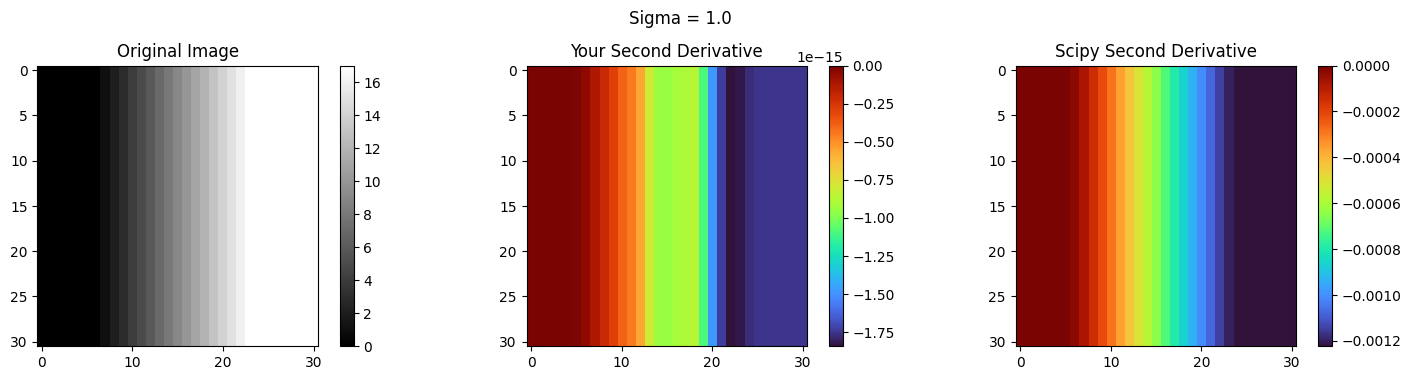

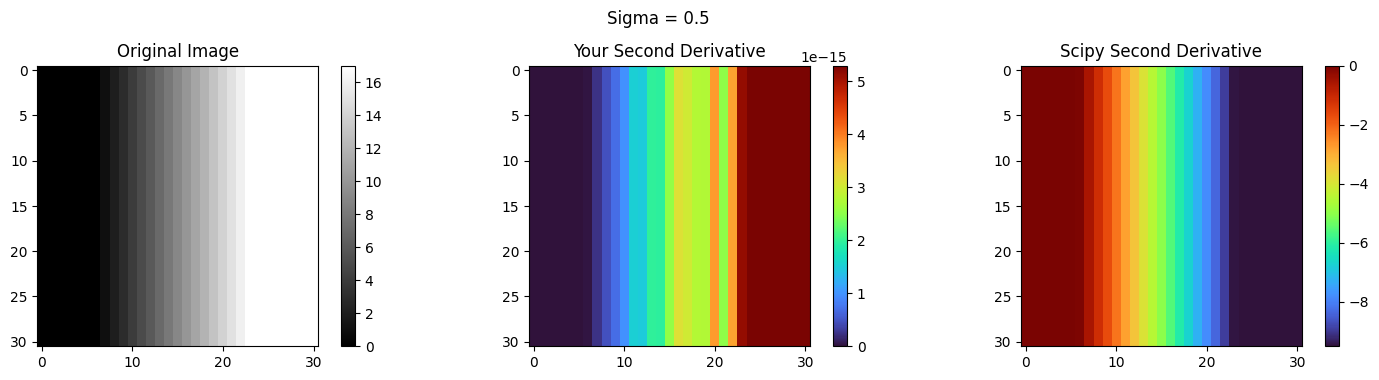

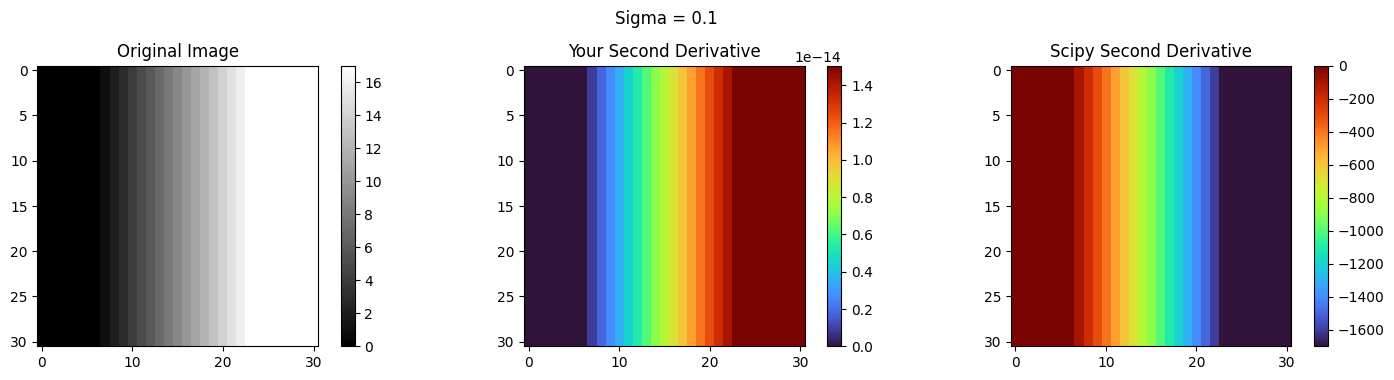

In [15]:
# Construct an image with a zero-valued second-derivative in the column-direction
img = torch.zeros(1, 1, 31, 31, dtype=torch.float64)
img[..., 7:24] += torch.arange(1, 18)
img[..., 24:] += 17

for sigma in [1.0, 0.5, 0.1]:
    # Apply your second-derivative filter
    our_second_derivative = second_order_yy(img, sigma=sigma)

    # Apply the second-derivative filter using scipy
    scipy_second_derivative = gaussian_filter_scipy(
        img.numpy().squeeze(), sigma=sigma, order=[2, 0]
    )

    # Plot the original image and the filtered images
    plt.figure(figsize=(15, 3.75))
    plt.subplot(131)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(our_second_derivative.squeeze(), cmap="turbo")
    plt.title("Your Second Derivative")
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(scipy_second_derivative, cmap="turbo")
    plt.title("Scipy Second Derivative")
    plt.colorbar()

    plt.suptitle(f"Sigma = {sigma}")
    plt.tight_layout()
    plt.show()

Test your other filters

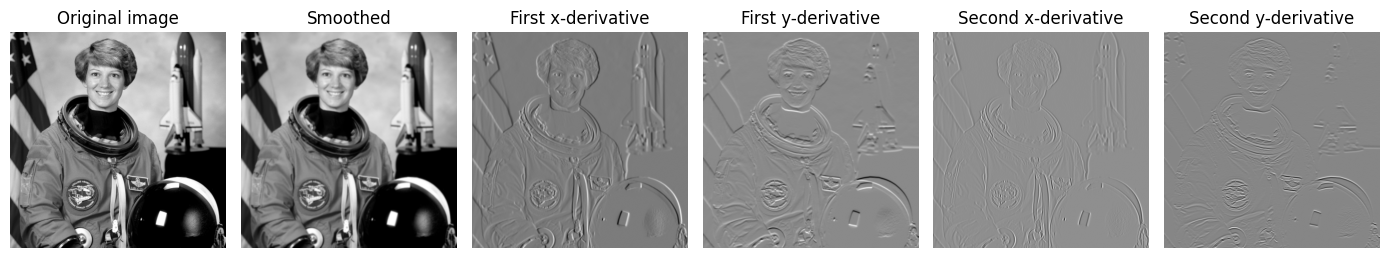

In [16]:
sigma = 1
fig, axs = imshow(
    img := astronaut(),
    zeroth_order(img, sigma),
    first_order_x(img, sigma),
    first_order_y(img, sigma),
    second_order_xx(img, sigma),
    second_order_yy(img, sigma),
)
axs[0].set_title("Original image")
axs[1].set_title("Smoothed")
axs[2].set_title("First x-derivative")
axs[3].set_title("First y-derivative")
axs[4].set_title("Second x-derivative")
axs[5].set_title("Second y-derivative")
plt.show()

## Part 3.3: Implementing the Laplacian of Gaussian (LoG) filter

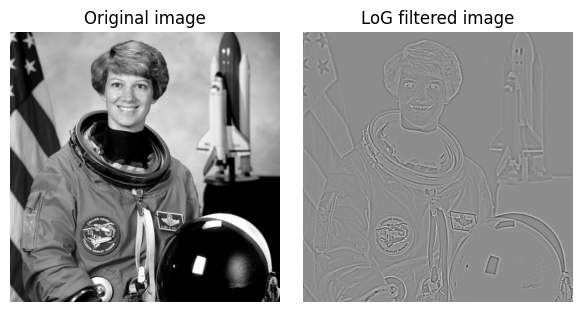

In [17]:
sigma = 1
fig, axs = imshow(
    img := astronaut(),
    log(img, sigma),
)
axs[0].set_title("Original image")
axs[1].set_title("LoG filtered image")
plt.show()

## Part 3.4: Steerable Filters

Steerable filters are very useful, but they also reveal an interesting property about rotations.

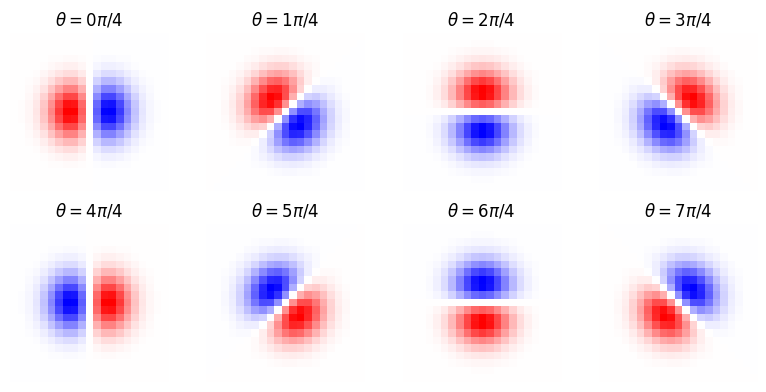

In [18]:
# Verify your 2D filters are properly oriented
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for idx, ax in enumerate(axs.flatten()):
    ax.imshow(oriented_filter(idx * torch.pi / 4, 2.5), cmap="bwr")
    ax.axis("off")
    ax.set_title(f"$\\theta = {idx} \\pi / 4$")
plt.tight_layout()
plt.show()

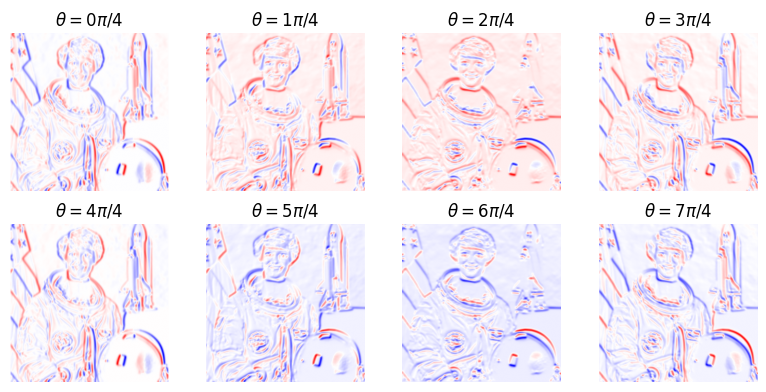

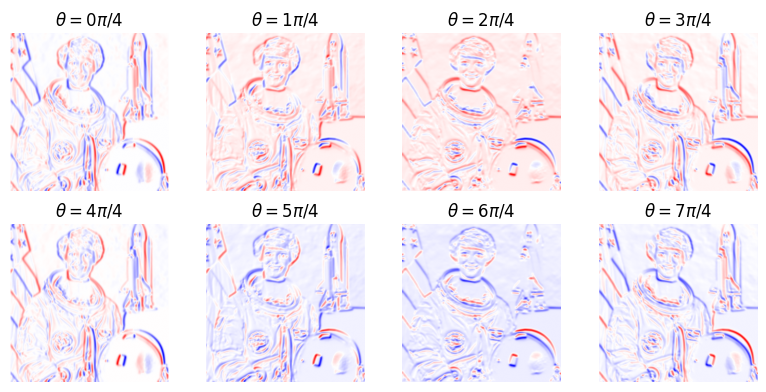

In [20]:
# Steer the filter
steered_filter = []
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for idx, ax in enumerate(axs.flatten()):
    theta = idx * torch.pi / 4
    img = steer_the_filter(astronaut(), theta=theta, sigma=2.5)
    ax.imshow(img.squeeze(), cmap="bwr")  # , vmin=-.125, vmax=.125)
    ax.axis("off")
    ax.set_title(f"$\\theta = {idx} \\pi / 4$")
    steered_filter.append(img)
plt.tight_layout()
plt.show()

# Steer the image
steered_images = []
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for idx, ax in enumerate(axs.flatten()):
    theta = idx * torch.pi / 4
    out = steer_the_images(astronaut(), theta=theta, sigma=2.5)
    ax.imshow(out.squeeze(), cmap="bwr")  # |, vmin=-.125, vmax=.125)
    ax.axis("off")
    ax.set_title(f"$\\theta = {idx} \\pi / 4$")
    steered_images.append(out)
plt.tight_layout()
plt.show()

In [21]:
# Assert that the steered filter and steered image are the same... curious!
torch.allclose(
    torch.cat(steered_filter),
    torch.cat(steered_images),
    atol=1e-6,
)

True

## Part 3.5

For the final part of this problem set, use what you know about steerable filters to make a new filter that measures the orientation of edges in an image. Test your implementation of `src.steerable.measure_orientation` on the `hubble` image below.

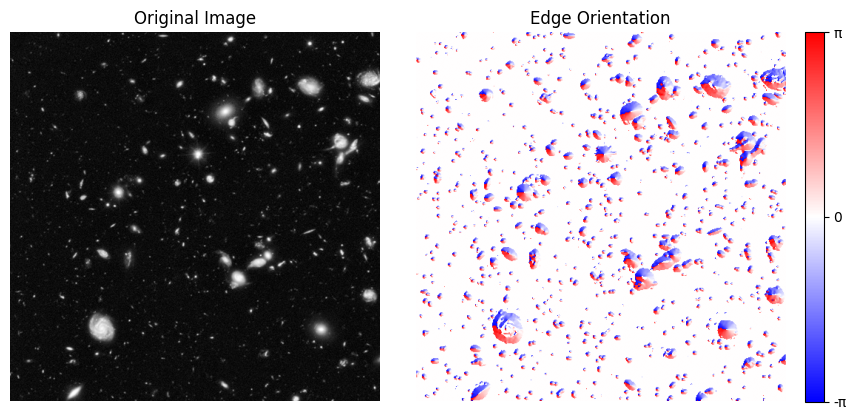

In [22]:
# Measure the orientation of edges in the image
img = hubble()
orientations = measure_orientation(img, sigma=1)

# Plot the original image and the orientation of edges
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.5, 4), constrained_layout=True)
ax1.imshow(img.squeeze(), cmap="gray")
ax1.set_title("Original Image")
ax1.axis("off")

im = ax2.imshow(orientations.squeeze(), cmap="bwr", vmin=-torch.pi, vmax=torch.pi)
ax2.set_title("Edge Orientation")
ax2.axis("off")

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(
    im,
    cax=cax,
    ticks=[-torch.pi, 0, torch.pi],
    format=lambda x, _: "-π" if x < 0 else ("π" if x > 0 else "0"),
)

ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.savefig("../img/hubble.png", bbox_inches="tight", pad_inches=0)
plt.show()